# Building the complete model

## Import Libraries

In [1]:
import pandas as pd
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, average_precision_score, recall_score

# from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from VennABERS import ScoresToMultiProbs

import matplotlib.pyplot as plt
%matplotlib notebook

# from costcla.models import CostSensitiveRandomForestClassifier

%autosave 0

Autosave disabled


## Import Data

The `format` parameters options are: 'numpy_array' or None which returns the panda dataframes

In [2]:
def import_data(format=None):
    data = pd.read_csv('/Users/steliosrammos/Documents/Education/Maastricht/DKE-Year3/Bachelor Thesis/data/v2/data_merged_2018.csv', sep=';')
    # data.head()
    
    X, y, s = None, None, None
    
    X = data.iloc[:,1:-2]
    s = data.iloc[:,-2]
    y = data.iloc[:,-1]        
    
    print(y.value_counts())
    X = X.fillna(X.mean().apply(lambda x: math.floor(x)))
    y.loc[s == 0] = np.nan
    
    # Nunmpy Arrays
    if format == 'numpy_array':
        X = X.values
        s = s.values
        y = y.values
    
    return X, s, y

## Model Building Functions

The `get_best_rfc_estimator` uses `GridSearchCV` to find the best parameters for the given classifier.

In [17]:
def get_best_rfc_estimator(X_train, X_test, y_train, y_test, verbose=False):

    skf_2 = StratifiedKFold(2, random_state=1)
    skf_10 = StratifiedKFold(10, shuffle=True, random_state=1)
    
    clf = RFECV(RandomForestClassifier(n_estimators=100, random_state=1), step=5, cv=skf_2, scoring="roc_auc")
    clf.fit(X_train, y_train)
    mask = clf.support_
    
    X_train = X_train[:,mask]
    X_test = X_test[:,mask]
    # Parameters for the grid search 
    parameters = {
        'random_state':[1],
        'n_jobs': [-1],
        'n_estimators':[150, 300],
        'criterion':['entropy', 'gini'],
        'bootstrap':[True],
    }

    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc, param_grid=parameters, cv=skf_10, scoring="roc_auc",verbose=0)
    grid.fit(X_train, y_train)
    
    if verbose:
        predicted_y = grid.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predicted_y)

        print(
            'Best parameters: {}'.format(grid.best_params_),
            'ROC {}'.format(roc_auc),
            'Accuracy {}'.format(accuracy_score(y_test, predicted_y)),
            'Precision {}'.format(precision_score(y_test, predicted_y)),
            'Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, predicted_y))
        )
    
    return grid.best_estimator_, grid.best_score_

The function `classify_rfc` uses the best estimator returned by `get_best_rfc_estimator` to fit and predict the data

In [18]:
def classify_rfc(X_train, X_test, y_train, y_test, rfc=None):
    # Parameters for the grid search
    if rfc is None:
        rfc = RandomForestClassifier(bootstrap=True, criterion="gini", n_estimators=100, n_jobs=-1, random_state=1,
                                 oob_score=True)

    estimator = rfc.fit(X_train, y_train)
    predicted_proba = estimator.predict_proba(X_test)
    
    proba_y = predicted_proba[:, 1]
    training_scores = estimator.oob_decision_function_

#     print(
#         'Average probability of predicted s (non-calibrated): {}'.format(np.mean(proba_y, axis=0)),
#         'ROC uncalibrated: {}'.format(roc_auc_score(y_test, proba_y))
#     )
    
    return predicted_proba, training_scores, proba_y

In [19]:
def classify_rfc_calibrated(X_train, X_test, y_train, y_test, rfc=None):
    # Parameters for the grid search
    if rfc is None:
        rfc = RandomForestClassifier(bootstrap=True, criterion="gini", n_estimators=100, n_jobs=-1, random_state=1,
                                 oob_score=True)

#     estimator = rfc.fit(X_train, y_train)
    isotonic = CalibratedClassifierCV(rfc, cv=2, method='isotonic')
    estimator = isotonic.fit(X_train, y_train)
    
    predicted_proba = isotonic.predict_proba(X_test)
    
    proba_y = predicted_proba[:, 1]
    
#     print(
#         'Average probability of predicted s (non-calibrated): {} \n'.format(np.mean(proba_y, axis=0)),
#         'ROC calibrated: {}'.format(roc_auc_score(y_test, proba_y))
#     )
    
    return predicted_proba, proba_y

The function `calibrate` is pretty self-explanatory. It returns calibrated probability estimates for each label.

In [20]:
def calibrate(test_scores, train_scores):
    calibr_pts = []
    
    for i in range(0,train_scores.shape[0]):
        label = np.argmax(train_scores[i,:])
        score = train_scores[i, label]
        calibr_pts.append([score, label])
        
    p0, p1 = ScoresToMultiProbs(calibr_pts, test_scores)
#     print('p0: {} \n'.format(p0.shape), p0)
#     print('p1: {} \n'.format(p1.shape), p1)
#     print(p0,p1)
    p = log_loss(p0, p1)
#     print('Average probability of predicted s (calibrated): {}'.format(np.mean(p, axis =0)))
    return p
    

In [21]:
def log_loss(p0, p1):
    
    p = []
    
    for i in range(0, p0.shape[0]):
        p0_single = p1[i, 0] / (1 - p0[i, 0] + p1[i, 0])
        p1_single = p1[i, 1] / (1 - p0[i, 1] + p1[i, 1])
        
        p.append([p0_single, p1_single])
        
    p = np.array(p)
    
    return p

In [22]:
def plot_calibration_curve(y_test, prob_y, name, ax):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_y)

    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=name)

The function `build_model` calls all the above functions and returns the best cross-validated and calibrated estimator alognside it's scoring.

In [40]:
def build_model(X, y, classifier):

    # Select the correct classifier
    if classifier == 'RandomForestClassifier':
        classify_function = get_best_rfc_estimator
    elif classifier == 'SVM':
        classify_function = get_best_svm_estimator
    else:
        return 'The classifier provided is not handled'

    # Initiate some variables and parameters
    skf = StratifiedKFold(10, shuffle=True, random_state=1)
    roc_scores = []
    classifiers = []
    i = 0
    predicted_proba_trial = None
    
    # Initiate figure for plotting calibration curve
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title('Calibration plots  (reliability curve)')
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     plt.tight_layout()
    
    # Debug variables
    trial = False
    trial_iterations = 2


    # Cross validation training
    for train_index, test_index in skf.split(X, y):
        if i <= trial_iterations -1:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if trial:
                test_score, training_score, proba_y = classify_rfc(X_train, X_test, y_train, y_test)
                _, calibrated_proba_y = classify_rfc_calibrated(X_train, X_test, y_train, y_test)
        
#                 print(
#                     'Probability of s (test sample): {} \n'.format(np.count_nonzero(y_test)/len(y_test)),
#                     'Probability of s (full dataset): {} \n'.format(np.count_nonzero(y)/len(y)),
#                     'Training set scores shape: {} \n'.format(training_score.shape),
#                     'Predicted proba shape: {} \n'.format(test_score.shape)
#                 )
                
                p = calibrate(test_score, training_score)
                custom_calibrated_proba_y = p[:,1]
                
#                 print('ROC calibrated custom: {}'.format(roc_auc_score(y_test, custom_calibrated_proba_y)))

                plot_calibration_curve(y_test, proba_y, 'RFC CV {}'.format(i), ax)
                plot_calibration_curve(y_test, calibrated_proba_y, 'RFC calibrated CV {}'.format(i), ax)
                plot_calibration_curve(y_test, custom_calibrated_proba_y, 'RFC calibrated Venn ABERS CV {}'.format(i), ax)
            
            else:
                estimator, roc_score_grid = classify_function(X_train, X_test, y_train, y_test)
                
                # Calibrate estimator
                isotonic = CalibratedClassifierCV(estimator, cv=2, method='isotonic')
                clf = isotonic.fit(X_train, y_train)

                predicted_proba = isotonic.predict_proba(X_test)
                proba_y = predicted_proba[:, 1]
                roc_score = roc_auc_score(y_test, proba_y)
                
#                 print(
#                     'Grid Search ROC AUC in CV {}: {} \n'.format(i, roc_score_grid),
#                     'Calibrated ROC AUC in CV {}: {} \n'.format(i, roc_score),
#                     '\n'
#                 )
                
                # Plot calibration curve
                plot_calibration_curve(y_test, proba_y, 'RFC calibrated CV {} - ROC {}'.format(i, roc_score), ax)
                
                classifiers.append(clf)
                roc_scores.append(roc_score)

            i += 1
    
    plt.legend(loc="best")
    plt.show()
    
    if not trial:
        best_index = np.argmax(roc_scores)
        best_roc_score = roc_scores[best_index]
        best_classifier = classifiers[best_index]
        
        return best_classifier, best_roc_score
    
    else:
        return None, None

## Building Classifier S

1.0    1476
0.0     362
Name: finished_treatment, dtype: int64


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>


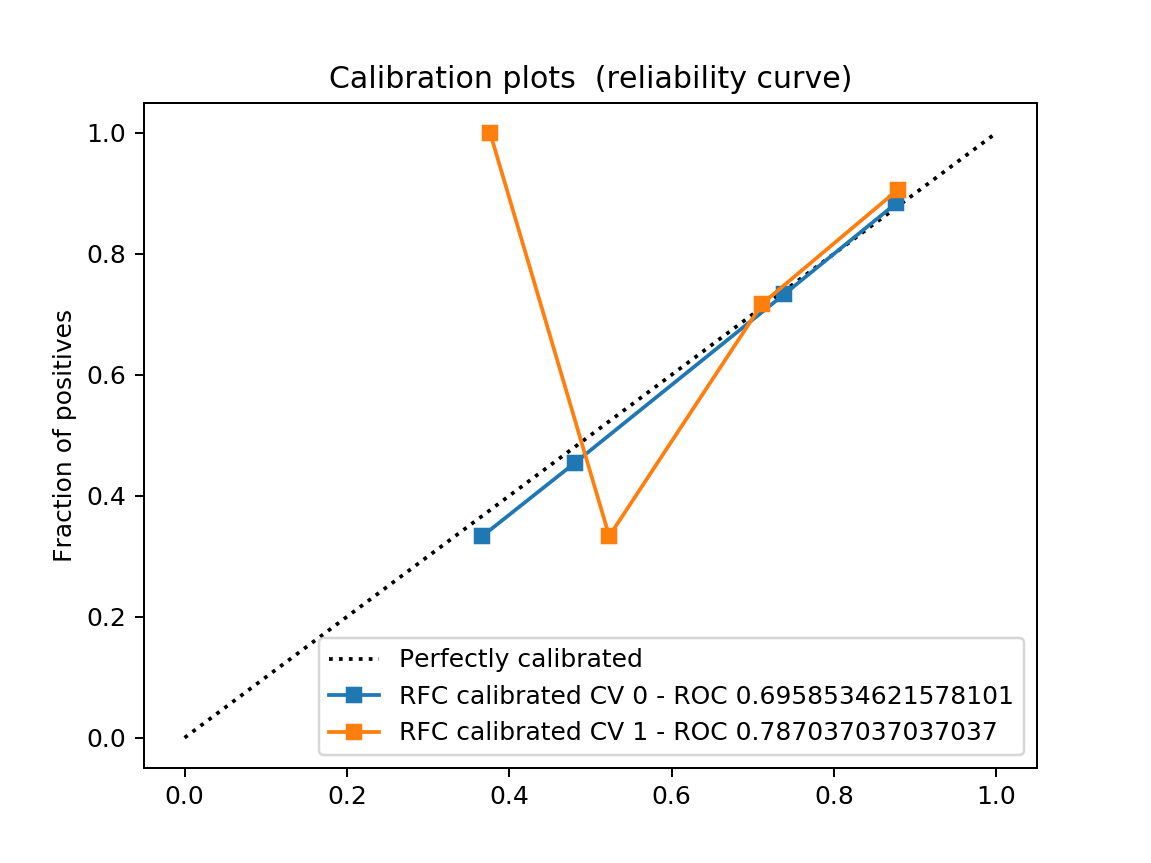

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<IPython.core.display.Javascript object>


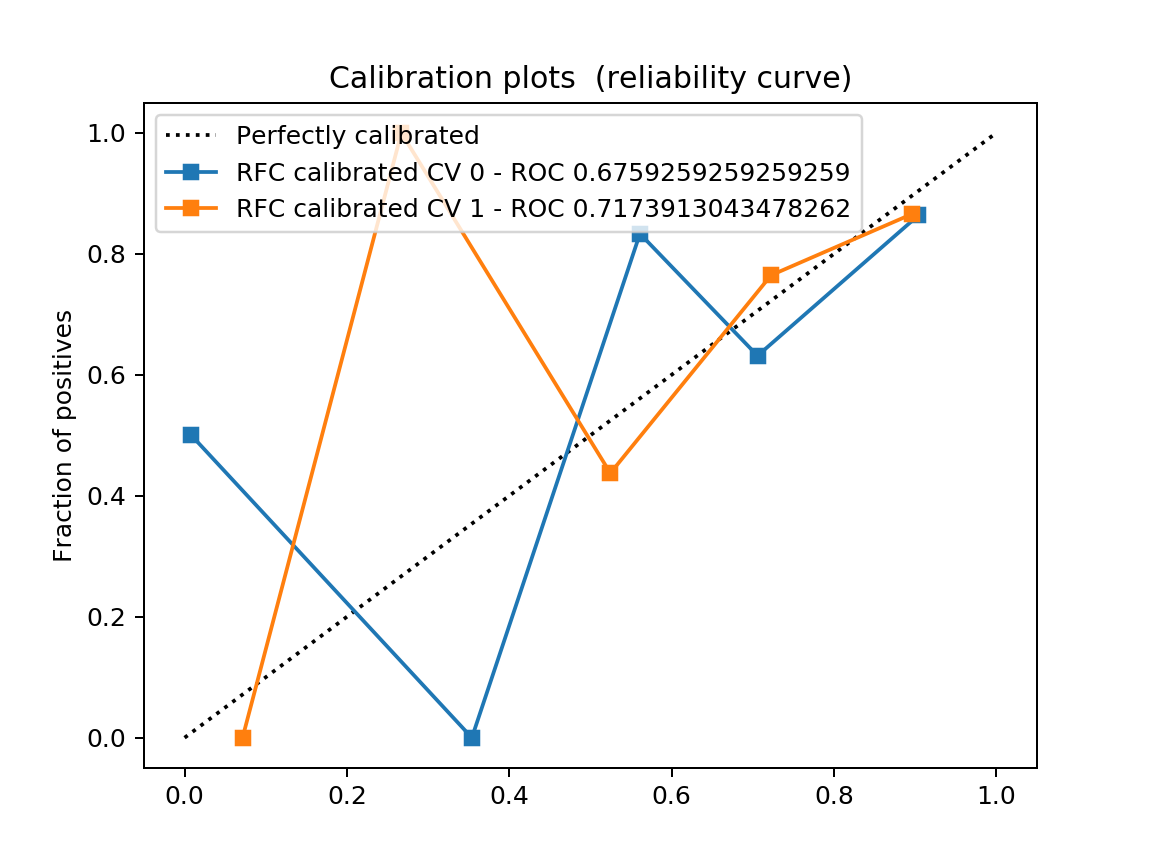

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
X,s,_ = import_data('numpy_array')

skf = StratifiedKFold(2, shuffle=True, random_state=1)

for train_index, test_index in skf.split(X, s):
    X_train, X_test = X[train_index], X[test_index]
    s_train, s_test = s[train_index], s[test_index]
    
    classifier_s, roc_score = build_model(X_train,s_train,'RandomForestClassifier')
    prob_predicted_s = classifier_s.predict(X_test)
    accuracy = accuracy_score(prob_predicted_s, s_test)

In [45]:
accuracy

0.7946127946127947

In [31]:
classifier_s 

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
            cv=2, method='isotonic')

In [38]:
prob_predicted_s = classifier_s.predict(X)
prob_predicted_s

array([1, 1, 1, ..., 1, 0, 1])

In [39]:
accuracy = accuracy_score(prob_predicted_s, s)
accuracy

0.9061447811447811

## Compute Correction Coefficient 

In [369]:
def compute_corr_coef(prob_s, prob_predicted_s):
    
    corr_coeff = np.zeros(prob_predicted_s.shape[0])
    
    for i in range(0,prob_predicted_s.shape[0]): 
        corr_coeff[i] = prob_s / prob_predicted_s[i]
    
    return corr_coeff

In [370]:
prob_s = s[s==1].shape[0]/s.shape[0]
corr_coeff = compute_corr_coef(prob_s, prob_predicted_s)

corr_coeff

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


array([1.0333649 , 0.8170319 , 0.89603183, ..., 0.82733248, 2.01864679,
       0.8170319 ])

## Building Classifier Y

1.0    1476
0.0     362
Name: finished_treatment, dtype: int64


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>


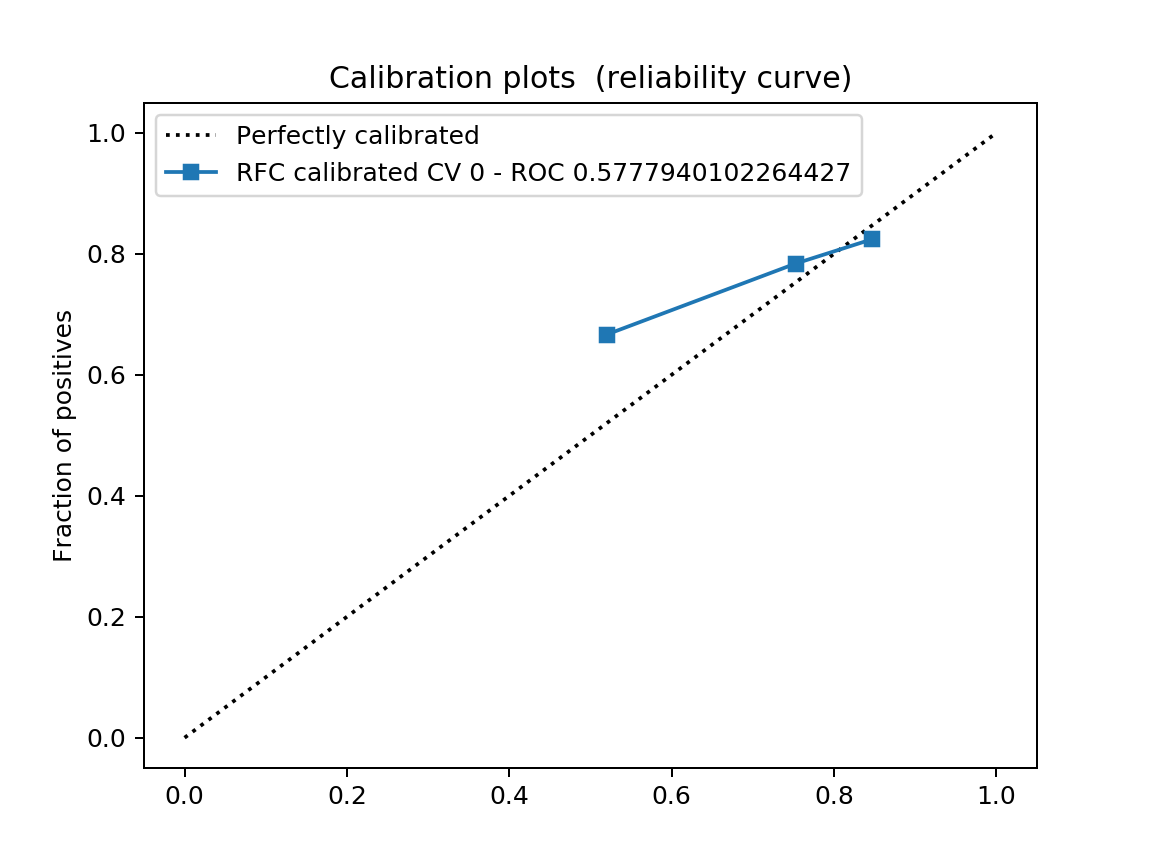

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [348]:
X,_,y = import_data()

X_lab = X.loc[~y.isna(), :].values
y_lab = y[~y.isna()].values

X_unlab = X.loc[y.isna(), :].values

classifier_y, roc_score = build_model(X_lab,y_lab,'RandomForestClassifier')

In [236]:
classifier_y

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
            cv=2, method='isotonic')

In [357]:
predicted_y = classifier_y.predict_proba(X_unlab)

In [356]:
np.count_nonzero(predicted_y)/predicted_y.shape[0]

0.9814126394052045

In [361]:
predicted_y.mean(axis=0)

array([0.22692311, 0.77307689])

In [6]:
X,_,y = import_data()
print(X.shape)
np.linalg.matrix_rank(X)

1.0    1476
0.0     362
Name: finished_treatment, dtype: int64
(2376, 64)


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


61